<a href="https://colab.research.google.com/github/benjaminnigjeh/VAEMS/blob/main/FCVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and dependencies

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import TensorBoard
from google.colab import files

# Set up the tensorboard callback function

In [2]:
NAME = "Unsupervised_clustering"
tensorboard = TensorBoard(
    log_dir='/content/{}'.format(NAME))

# Upload dataset from a local folder

the number of features is equal to n_dim squared

In [3]:
n_dim = 88
dataset = files.upload_file('dataset')
df = pd.read_csv('/content/dataset')
X = df.copy()
Y = X.pop("target")
X_np = np.array(X)
x_train = np.reshape(X_np,(-1, n_dim, n_dim, 1))
y_train = np.array(Y)


Saved pancreatic_tissue.csv to /content/dataset


# Define the n dimensions for the latent space

In [4]:
latent_dim = 2

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder and decoder architure and VAE class

In [5]:
encoder_inputs = keras.Input(shape=(n_dim, n_dim, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(120 , activation="relu")(x)
x = layers.Dense(120 , activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(n_dim * n_dim * 1, activation="relu")(latent_inputs)
x = layers.Dense(n_dim * n_dim * 1, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((n_dim, n_dim, 1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }




Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 88, 88, 1)]          0         []                            
                                                                                                  
 flatten (Flatten)           (None, 7744)                 0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 120)                  929400    ['flatten[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 120)                  14520     ['dense[0][0]']               
                                                                                            

# Train the model

Epoch 1/500
2/2 [==============================] - 3s 608ms/step - loss: 4867.9798 - reconstruction_loss: 4922.2212 - kl_loss: 6.5958
Epoch 2/500
2/2 [==============================] - 1s 606ms/step - loss: 4791.5758 - reconstruction_loss: 4776.0605 - kl_loss: 8.0902
Epoch 3/500
2/2 [==============================] - 1s 606ms/step - loss: 4873.1943 - reconstruction_loss: 4848.6562 - kl_loss: 10.3175
Epoch 4/500
2/2 [==============================] - 1s 600ms/step - loss: 4772.0861 - reconstruction_loss: 4764.5317 - kl_loss: 9.0694
Epoch 5/500
2/2 [==============================] - 2s 889ms/step - loss: 4797.0130 - reconstruction_loss: 4802.4170 - kl_loss: 7.6595
Epoch 6/500
2/2 [==============================] - 1s 614ms/step - loss: 4788.5617 - reconstruction_loss: 4774.0742 - kl_loss: 7.6341
Epoch 7/500
2/2 [==============================] - 1s 590ms/step - loss: 4743.8237 - reconstruction_loss: 4751.2207 - kl_loss: 8.4881
Epoch 8/500
2/2 [==============================] - 1s 617ms/s

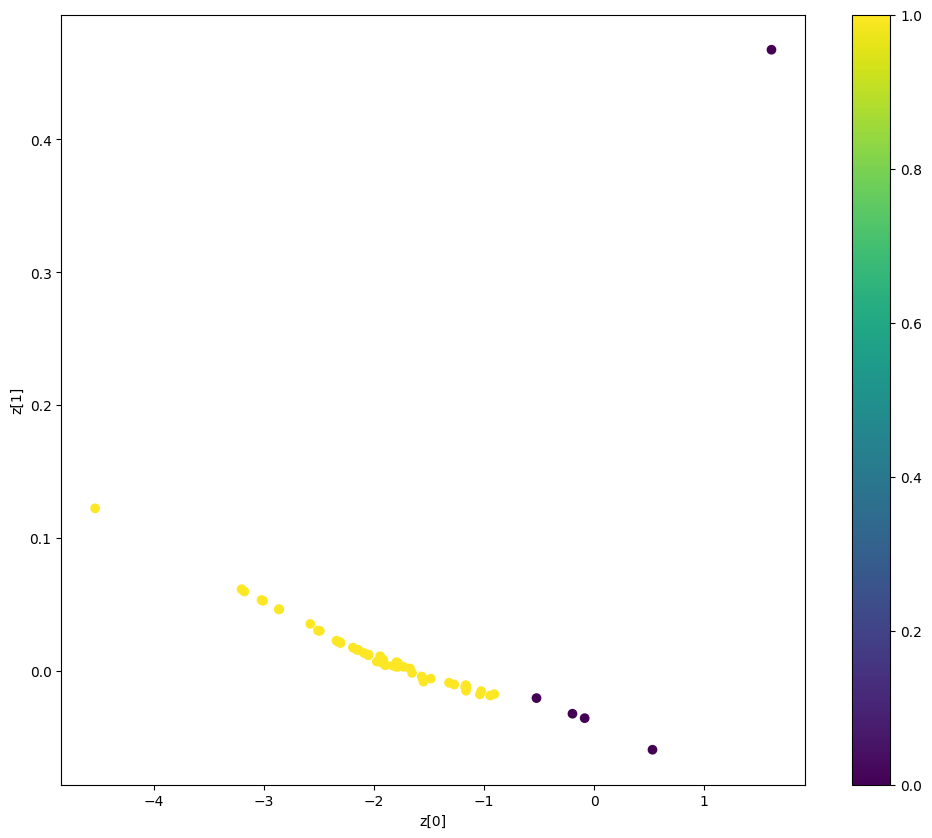

In [13]:

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=500, callbacks=[tensorboard])

def plot_label_clusters(vae, data, labels):
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
plot_label_clusters(vae, x_train, y_train)

# Estimation of euclidian distance in the binary clusters

In [ ]:
data = []
length = len(y_train)

for i in range(0, length, 1):
    b = np.reshape(x_train[i], (1, n_dim, n_dim, 1))
    z_mean, _, _ = vae.encoder.predict(b)
    c = np.array([[z_mean[:, 0], z_mean[:, 1]]])
    c = np.reshape(c, (2, 1))
    c = np.transpose(c)
    data.append(c)

data = np.array(data)
data = np.reshape(data, (length, 2))
y_train_label = np.reshape(y_train, (length, 1))
data = np.concatenate((data, y_train_label), axis=1)
means_cluster_1 = data[0:int(length/2), :2].mean(axis=0)
means_cluster_2 = data[int(length/2):length+1, :2].mean(axis=0)
dist = np.linalg.norm(means_cluster_1-means_cluster_2)
print("Euclidian distance is ", dist)